In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc as pm
import collections
from scipy.stats import skellam
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [48]:
# Load and segment dataset
goals = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
goals.to_csv('goals.csv')
goals = goals[['HomeTeam','AwayTeam','FTHG','FTAG']] 
goals = goals.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
goals = goals[:-10]
home_average = goals['HomeGoals'].mean()
away_average = goals['AwayGoals'].mean()

In [3]:
away_average

1.1837837837837837

In [4]:
home_dict = collections.Counter(goals['HomeGoals'].values.flatten())
home = pd.DataFrame.from_dict(home_dict, orient='index')

In [5]:
away_dict = collections.Counter(goals['AwayGoals'].values.flatten())
away = pd.DataFrame.from_dict(away_dict, orient='index')

In [6]:
home_sum = home.sum()
away_sum = away.sum()
home = home / home_sum
away = away / away_sum
df = pd.concat([home, away], axis=1)

[0, 1, 2, 3, 4, 5, 6]
[0.1353352832366127, 0.2706705664732254, 0.2706705664732254, 0.18044704431548356, 0.09022352215774178, 0.03608940886309672, 0.012029802954365565]


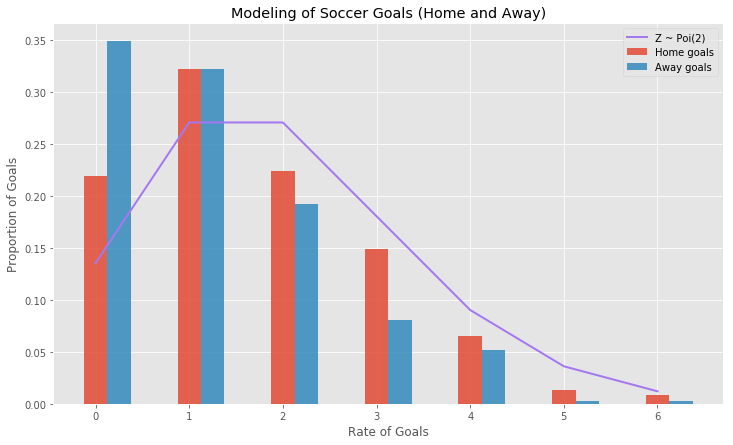

In [7]:
from scipy.stats import poisson

poission_arr = []
rv = poisson(2)
for num in range(0, 7):
    poission_arr.append(rv.pmf(num))

print range(0, 7)
print poission_arr
x = range(0, 7)

plt.rcParams['figure.figsize'] = [12, 7]
width = 0.25

plt.plot(x, poission_arr, c="#A578F1", alpha=1, linewidth=2.0, linestyle = '-', label="Z ~ Poi(2)")
plt.bar(df.index.values, df.iloc[:, 0], width, alpha=0.85, label="Home goals")
plt.bar(df.index.values + width, df.iloc[:, 1], width, alpha=0.85, label="Away goals")
plt.title("Modeling of Soccer Goals (Home and Away)")
plt.ylabel("Proportion of Goals")
plt.xlabel("Rate of Goals")
plt.legend(loc="upper right")

In [8]:
mean, var, skew, kurt = skellam.stats(home_average, away_average, moments='mvsk')
print home_average, away_average, mean, var, skew, kurt
skellam.pmf(0, home_average, away_average)

1.5918918918918918 1.1837837837837837 0.40810810810810816 2.7756756756756755 0.08825150978596796 0.36027263875365145


0.24809376810717076

In [9]:
print "mu for home: %.2f" % home_average
print "mu for away: %.2f" % away_average
print "The probability of a draw is %.2f" % skellam.pmf(0, home_average, away_average)
print "The probability of away winning by 1 goal is %.3f" % skellam.pmf(1, away_average, home_average)
print "The probability of away loosing by 1 goal is %.3f" % skellam.pmf(-1, away_average, home_average)
print "The probability of home winning by 3 goals is %.3f" % skellam.pmf(3, home_average, away_average) 
print "The probability of away winning by 1, 2, or 3 goals is %.3f" % skellam.pmf([1, 2, 3], away_average, home_average).sum()
print "The probability of home winning by at least 1 goal is %.3f" % skellam.pmf([range(1, 7)], home_average, away_average).sum()
print "The probability of away loosing by at least 2 goals is %.3f" % skellam.pmf([range(-7, -1)], away_average, home_average).sum()

mu for home: 1.59
mu for away: 1.18
The probability of a draw is 0.25
The probability of away winning by 1 goal is 0.169
The probability of away loosing by 1 goal is 0.227
The probability of home winning by 3 goals is 0.066
The probability of away winning by 1, 2, or 3 goals is 0.274
The probability of home winning by at least 1 goal is 0.468
The probability of away loosing by at least 2 goals is 0.241


In [10]:
N = 7

alpha_home = 1.0 / home_average
lambda_home = pm.rexponential(alpha_home, 1) # Random
data_home = pm.rpoisson(lambda_home) 

alpha_away = 1.0 / away_average 
lambda_away = pm.rexponential(alpha_away, 1)
data_away = pm.rpoisson(lambda_away) 

In [13]:
print alpha_home, alpha_away
print lambda_home, lambda_away
print data_home, data_away

0.6281833616298812 0.8447488584474887
lambda_home lambda_away
[5] [0]


In [14]:
lambda_home = pm.Exponential("lambda_home", alpha_home)
lambda_away = pm.Exponential("lambda_away", alpha_away)
print lambda_home.random(), lambda_home.random(), lambda_home.random() # Three randrom values for lambda_home

3.170940045379328 0.6428919148661894 0.325738343174905


In [15]:
# np.zeros(len(goals['HomeGoals']))

In [16]:
@pm.deterministic
def lambda_h_(lambda_home=lambda_home):
    out = np.zeros(len(goals['HomeGoals']))
    out[:] = lambda_home
    return out

In [17]:
@pm.deterministic
def lambda_a_(lambda_away=lambda_away):
    out = np.zeros(len(goals['AwayGoals']))
    out[:] = lambda_away
    return out

In [18]:
oberservation_h = pm.Poisson("obs_h", lambda_h_, value=goals['HomeGoals'], observed=True)
oberservation_a = pm.Poisson("obs_a", lambda_a_, value=goals['AwayGoals'], observed=True)

model_h = pm.Model([oberservation_h, lambda_home])
model_a = pm.Model([oberservation_a, lambda_away])

In [19]:
mcmc_h = pm.MCMC(model_h)
mcmc_a = pm.MCMC(model_a)
mcmc_h.sample(40000, 10000)
mcmc_a.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 3.4 sec

In [20]:
lambda_h_samples = mcmc_h.trace('lambda_home')[:]
lambda_a_samples = mcmc_a.trace('lambda_away')[:]

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.8, 1.8)

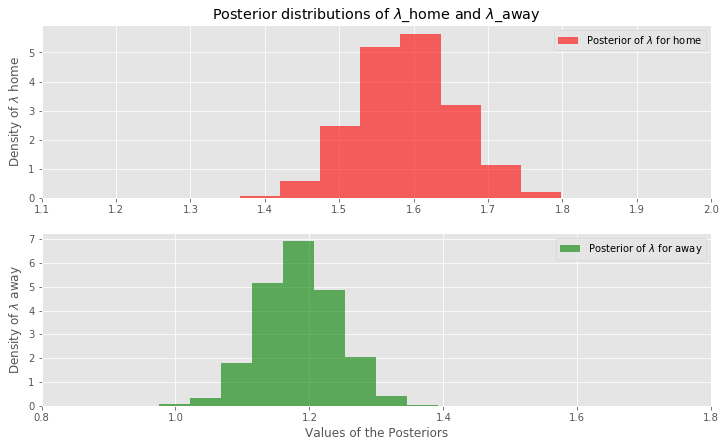

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.subplot(211)

# Graph one
plt.hist(lambda_h_samples, histtype='stepfilled', color='red', alpha=0.60, normed=True, label=r"Posterior of $\lambda$ for home")
plt.title(r"Posterior distributions of $\lambda$_home and $\lambda$_away")
plt.ylabel(r"Density of $\lambda$ home")
plt.legend(loc="upper right")
plt.xlim([1.1, 2])

# Graph two
ax = plt.subplot(212)
plt.hist(lambda_a_samples, histtype='stepfilled', color='green', alpha=0.60, normed=True, label=r"Posterior of $\lambda$ for away")
plt.legend(loc="upper right")
plt.xlabel("Values of the Posteriors")
plt.ylabel(r"Density of $\lambda$ away")
plt.xlim([.8, 1.8])

In [22]:
lambda_h_samples_mean = lambda_h_samples.mean()
lambda_a_samples_mean = lambda_a_samples.mean()

print "The mean of lambda_h_samples_mean is: %.4f" % lambda_h_samples_mean
print "The mean of lambda_a_samples_mean is: %.4f" % lambda_a_samples_mean

The mean of lambda_h_samples_mean is: 1.5915
The mean of lambda_a_samples_mean is: 1.1841


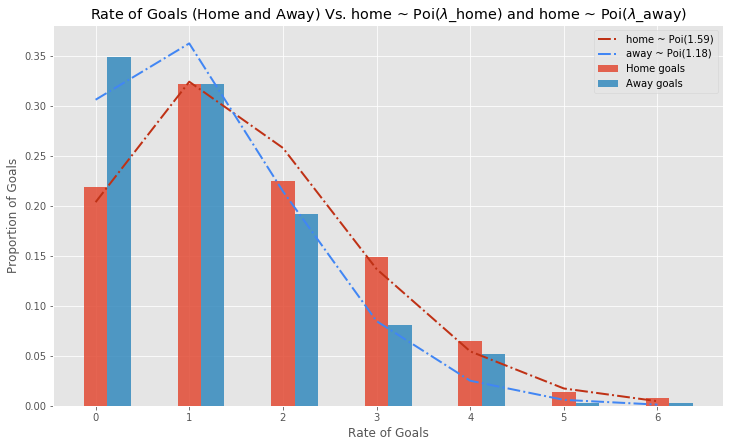

In [23]:
poission_arr_home = []
poission_arr_away = []

lambda_h_samples_mean = lambda_h_samples.mean()
lambda_a_samples_mean = lambda_a_samples.mean()

rv_h = poisson(lambda_h_samples_mean)
rv_a = poisson(lambda_a_samples_mean)

for num in range(0, 7):
    poission_arr_home.append(rv_h.pmf(num))
    poission_arr_away.append(rv_a.pmf(num))
    
x = range(0, 7)

plt.rcParams['figure.figsize'] = [12, 7]
width = 0.25

plt.plot(x, poission_arr_home, c="#bf3115", alpha=1, linewidth=2.0, linestyle = '-.', label="home ~ Poi(%.2f)" % lambda_h_samples_mean)
plt.plot(x, poission_arr_away, c="#4186f4", alpha=1, linewidth=2.0, linestyle = '-.', label="away ~ Poi(%.2f)" % lambda_a_samples_mean)
plt.bar(df.index.values, df.iloc[:, 0], width, alpha=0.85, label="Home goals")
plt.bar(df.index.values + width, df.iloc[:, 1], width, alpha=0.85, label="Away goals")
plt.title(r"Rate of Goals (Home and Away) Vs. home ~ Poi($\lambda$_home) and home ~ Poi($\lambda$_away)")
plt.ylabel("Proportion of Goals")
plt.xlabel("Rate of Goals")
plt.legend(loc="upper right")

In [40]:
# Creating some random data for the title image

x_1 = 0.5*np.random.randn(1000) + 1
y_1 = 1.9*np.random.randn(1000) - 2
x_2 = 1.3*np.random.randn(1000) + 1
y_2 = 2.4*np.random.randn(1000) - 1.5

Text(0,0.5,'Y Val')

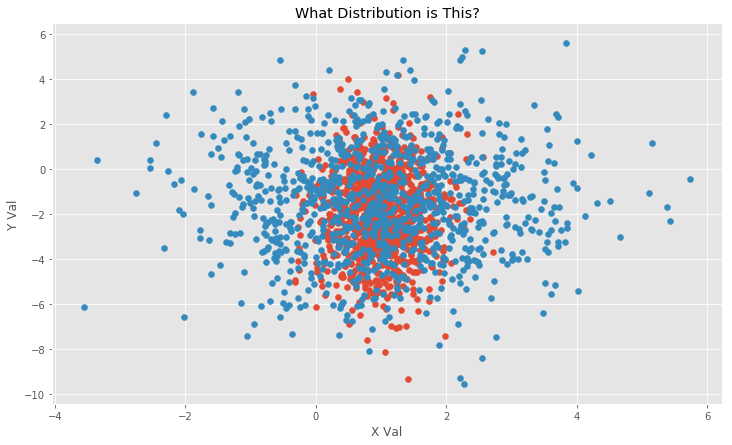

In [44]:
rng = range
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)
plt.title("What Distribution is This?")
plt.xlabel("X Val")
plt.ylabel("Y Val")